# Mercari Price Suggestion Challenge Data Preparation

This notebook is for initial preprocessing of data and creating custom sub datasets and train/test sets.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.column_data import *
from fastai.structured import *

import warnings
warnings.filterwarnings("ignore")

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('../data/')

TMP_PATH = DATA_PATH/'intermediate'
TMP_PATH.mkdir(exist_ok=True)

### Functions

In [4]:
def split_df(df, test_mask):
    df_train, df_test = df[~test_mask], df[test_mask]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

# na category names are just replaced with 'missing'
def split_cat(text):
    try:
        return text.split('/')
    except AttributeError:
        return tuple(['missing'] * 3)

# replace na or no description values with 'missing'
def fix_desc(text):
    return 'missing' if not isinstance(text, str) or text == 'No description yet' else text

In [5]:
split_cat('Men/Coats & Jackets/Flight/Bomber')

['Men', 'Coats & Jackets', 'Flight', 'Bomber']

In [6]:
tuple(['missing'] * 3)

('missing', 'missing', 'missing')

### Fixup Raw Data

In [7]:
train = pd.read_csv(DATA_PATH/'train.tsv', sep='\t')
test = pd.read_csv(DATA_PATH/'test.tsv', sep='\t')
test2 = pd.read_csv(DATA_PATH/'test_stg2.tsv', sep='\t')

In [8]:
test.rename(columns={'test_id': 'train_id'}, inplace=True)
test2.rename(columns={'test_id': 'train_id'}, inplace=True)

There are up to four categories that can be seperated from this string but I decided only to consider the first three.

In [9]:
train.category_name.str.count('/').max()

4.0

In [10]:
train[train.category_name.str.count('/') == 3].category_name.unique()

array(['Sports & Outdoors/Exercise/Dance/Ballet', 'Sports & Outdoors/Outdoors/Indoor/Outdoor Games',
       'Men/Coats & Jackets/Varsity/Baseball', 'Men/Coats & Jackets/Flight/Bomber',
       'Handmade/Housewares/Entertaining/Serving'], dtype=object)

Remove prices below `$3` as Merari does not allow postings below `$3` which makes it an error. There are `874` entries like that. Mercari also does not allow prices above `$2,000` but there are only 3 entries like that with only a few dollars more which are likely shipping fees. So removing them is not required.

In [11]:
train = train.drop(train[train['price'] < 3].index)

In [12]:
train.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...


Extract subcategories from the main `category_name` and remove it after as we don't need it.

In [13]:
train['main_cat'], train['sub_cat1'], train['sub_cat2'] = zip(*train['category_name'].apply(split_cat))                                                              
test['main_cat'], test['sub_cat1'], test['sub_cat2'] = zip(*test['category_name'].apply(split_cat))
test2['main_cat'], test2['sub_cat1'], test2['sub_cat2'] = zip(*test2['category_name'].apply(split_cat))

train.drop('category_name', inplace=True, axis=1)
test.drop('category_name', inplace=True, axis=1)
test2.drop('category_name', inplace=True, axis=1)

Replace `na` values in `brand_name` column with `missing`.

In [14]:
train['brand_name'].fillna(value='missing', inplace=True)
test['brand_name'].fillna(value='missing', inplace=True)
test2['brand_name'].fillna(value='missing', inplace=True)

The `name` column has nothing missing, but this is added just in case.

In [15]:
train['name'].fillna(value='missing', inplace=True)
test['name'].fillna(value='missing', inplace=True)
test2['name'].fillna(value='missing', inplace=True)

Convert `item_condition_id` and `shipping` column to `str` for easy conversion using FastAI's `proc_df`.

In [16]:
train['shipping'] = train['shipping'].astype('str')
test['shipping'] = test['shipping'].astype('str')
test2['shipping'] = test2['shipping'].astype('str')

train['item_condition_id'] = train['item_condition_id'].astype('str')
test['item_condition_id'] = test['item_condition_id'].astype('str')
test2['item_condition_id'] = test2['item_condition_id'].astype('str')

Replace `na` values and `No description yet` values in `item_description` with `missing`.

In [17]:
train['item_description'] = train['item_description'].apply(fix_desc)
test['item_description'] = test['item_description'].apply(fix_desc)
test2['item_description'] = test2['item_description'].apply(fix_desc)

Combine `name` and `item_description` into one field where the name and description are separated by a newline.

In [18]:
train['full_desc'] = train['name'].str.cat(train['item_description'], sep='\n')
test['full_desc'] = test['name'].str.cat(test['item_description'], sep='\n')
test2['full_desc'] = test2['name'].str.cat(test2['item_description'], sep='\n')

Drop these two columns since they are no longer needed.

In [19]:
train.drop('name', axis=1, inplace=True)
train.drop('item_description', axis=1, inplace=True)

test.drop('name', axis=1, inplace=True)
test.drop('item_description', axis=1, inplace=True)

test2.drop('name', axis=1, inplace=True)
test2.drop('item_description', axis=1, inplace=True)

### ! Replace training sets `price` column with its `np.log1p` !

In [20]:
train['price'] = np.log1p(train['price'])

This is done so that the values for index and `train_id` are not the same and that index reflects the true length of the dataframe such that the last index is of the value `len(df)-1`

In [21]:
train.reset_index(inplace=True, drop=True)

In [22]:
train.columns

Index(['train_id', 'item_condition_id', 'brand_name', 'price', 'shipping',
       'main_cat', 'sub_cat1', 'sub_cat2', 'full_desc'],
      dtype='object')

In [23]:
print(train['full_desc'][np.random.randint(0, len(train))])

✨ Kate Spade Wallet / Makeup Bag ✨
Matching red & brown KS wallet & makeup bag! Now flaws :)


### Create custom dataset from only the struct columns of the dataset

For now, use only the columns of the dataset, in addition the datasets contain `train_id` and `price`.

### Extract and create the sub-datasets

In [24]:
dep = ['price']
rid = ['train_id']
struct_vars = ['item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2']

In [25]:
test.columns

Index(['train_id', 'item_condition_id', 'brand_name', 'shipping', 'main_cat',
       'sub_cat1', 'sub_cat2', 'full_desc'],
      dtype='object')

In [26]:
for s in struct_vars: print (len(train[s].unique()))

5
4808
2
11
114
871


In [27]:
price = train[dep].as_matrix().flatten()
train = train[rid + struct_vars + dep]
test =  test[rid +  struct_vars]
test2 =  test2[rid +  struct_vars]

In [28]:
price

array([2.3979 , 3.97029, 2.3979 , ..., 2.56495, 3.82864, 3.13549])

### Split in training and test sets

The idea is to have a 10% data for test and 90% for train (and validation). The datasets are created as follows:
1. Get a random test mask of length 10% of the total training data
2. Extract the dependent variables for train and test using the mask
3. Extract train and test for each of the datasets

In [29]:
test_mask = train.index.isin(get_cv_idxs(n = len(train), val_pct=0.1))
y_test = price[test_mask]

In [30]:
test_mask

array([False, False, False, ..., False, False, False])

In [31]:
my_train, my_test = split_df(train, test_mask)
my_test.drop('price', axis=1, inplace=True)

In [32]:
train.shape

(1481661, 8)

In [33]:
my_train.shape

(1333495, 8)

### Check for errors

Get a random `train_id` and check if the row corresponding to that train id is the same on all dataframes.

In [34]:
r = np.random.choice(train['train_id'])
r

520714

In [35]:
rid

['train_id']

In [36]:
train.loc[(train[rid] == r).values.flatten()]

,train_id,item_condition_id,brand_name,shipping,main_cat,sub_cat1,sub_cat2,price
520436,520714,3,Hollister,0,Women,Coats & Jackets,Parka,3.555348


In [37]:
my_train.loc[(my_train[rid] == r).values.flatten()]

,train_id,item_condition_id,brand_name,shipping,main_cat,sub_cat1,sub_cat2,price
468590,520714,3,Hollister,0,Women,Coats & Jackets,Parka,3.555348


### Write to disk

Write each custom sub dataset to disk.

In [38]:
y_test.shape

(148166,)

In [39]:
my_test.shape

(148166, 7)

In [40]:
my_train.shape

(1333495, 8)

In [41]:
train.shape

(1481661, 8)

In [42]:
test.shape

(693359, 7)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481661 entries, 0 to 1481660
Data columns (total 8 columns):
train_id             1481661 non-null int64
item_condition_id    1481661 non-null object
brand_name           1481661 non-null object
shipping             1481661 non-null object
main_cat             1481661 non-null object
sub_cat1             1481661 non-null object
sub_cat2             1481661 non-null object
price                1481661 non-null float64
dtypes: float64(1), int64(1), object(6)
memory usage: 90.4+ MB


In [44]:
train.to_feather(TMP_PATH/'train.fth')
test.to_feather(TMP_PATH/'test.fth')

Write the dependent variable to disk for both test and training data.

In [45]:
np.save(TMP_PATH/'y_test.npy', y_test)

In [46]:
my_train.to_feather(TMP_PATH/'my_train.fth')
my_test.to_feather(TMP_PATH/'my_test.fth')

In [47]:
assert train.columns.all() == my_train.columns.all()
assert test.columns.all() == my_test.columns.all()

# Mercari Price Suggestion Challenge Structured Data

## Introduction

In this experiment, I consider all variables except `name` and `item_description` as part of the training features and label them as categorical (structured) data and create entity embeddings for them. This is part of the abalation study of how discarding `name` and `item_description` variables affects performance.

## Imports and Inits

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.structured import *
from fastai.column_data import *

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

torch.cuda.set_device(0)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH='../data/intermediate/'

In [4]:
MODELS_PATH = '../models/'

## My Definitions

### Functions

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def rmsle(y_pred, targ):
    '''Root Mean Squared Logarithmic Error'''
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(targ))**2))
        
def RMSE(preds, targs):
    assert(len(preds) == len(targs))
    return np.sqrt(mean_squared_error(targs, preds))    

Total number of epochs formula from [here](http://forums.fast.ai/t/n-epochs-cycle-len-cycle-mult-n-cycles/19106)

$n\_epochs = cycle\_len \cdot (1 + cycle\_mult + cycle\_mult^{2} + \cdots + cycle\_mult^{(n_{cycles}-1)})$

In [6]:
def get_epochs(n_cycle, cycle_len, cycle_mult):
    n_epochs = 0
    for cycle in range(n_cycle):
        n_epochs += cycle_mult ** cycle
    
    return cycle_len * n_epochs

## Load data and get validation indices

In [7]:
IS_SAMP = False

In [8]:
! pwd

/home/ubuntu/mercari/notebooks


In [9]:
# X_train = pd.read_feather(f'{PATH}/my_train.fth')
# X_test = pd.read_feather(f'{PATH}/my_test.fth')
X_train = pd.read_feather(f'{PATH}/train.fth')
X_test = pd.read_feather(f'{PATH}/test.fth')
y_test = np.load(f'{PATH}/y_test.npy')

In [10]:
X_train.shape

(1481661, 8)

In [11]:
X_test.shape

(693359, 7)

In [12]:
y_test.shape

(148166,)

In [13]:
X_train.head().T

,0,1,2,3,4
train_id,0,1,2,3,4
item_condition_id,3,3,1,1,1
brand_name,missing,Razer,Target,missing,missing
shipping,1,0,1,1,0
main_cat,Men,Electronics,Women,Home,Women
sub_cat1,Tops,Computers & Tablets,Tops & Blouses,Home Décor,Jewelry
sub_cat2,T-shirts,Components & Parts,Blouse,Home Décor Accents,Necklaces
price,2.3979,3.97029,2.3979,3.58352,3.80666


In [14]:
X_test.head().T

,0,1,2,3,4
train_id,0,1,2,3,4
item_condition_id,1,1,1,2,3
brand_name,missing,missing,Coach,missing,missing
shipping,1,1,1,0,1
main_cat,Women,Other,Vintage & Collectibles,Women,Other
sub_cat1,Jewelry,Office supplies,Bags and Purses,Sweaters,Books
sub_cat2,Rings,Shipping Supplies,Handbag,Cardigan,Religion & Spirituality


In [15]:
X_train.set_index('train_id', inplace=True)
X_test.set_index('train_id', inplace=True)

In [16]:
X_train.head()

,item_condition_id,brand_name,shipping,main_cat,sub_cat1,sub_cat2,price
train_id,,,,,,,
0,3,missing,1,Men,Tops,T-shirts,2.397895
1,3,Razer,0,Electronics,Computers & Tablets,Components & Parts,3.970292
2,1,Target,1,Women,Tops & Blouses,Blouse,2.397895
3,1,missing,1,Home,Home Décor,Home Décor Accents,3.583519
4,1,missing,0,Women,Jewelry,Necklaces,3.806662


In [17]:
100_000/len(X_train)

0.0674918216785081

In [18]:
# if IS_SAMP:
#     samp_idxs = get_cv_idxs(len(X_train), val_pct=100_000/len(X_train))
#     X_train = X_train.iloc[samp_idxs]

#### Change any columns of strings in a panda's dataframe to a column of categorical values. Apply changes inplace.

In [19]:
train_cats(X_train) 
apply_cats(X_test, X_train)

In [20]:
df_train, y_train, nas = proc_df(X_train, 'price')
df_test, _, nas = proc_df(X_test, na_dict=nas)

In [21]:
val_idxs = get_cv_idxs(len(df_train), val_pct=0.15, seed=None)
y_range = (0, np.max(y_train) * 1.5)

In [22]:
y_range

(0, 11.408835001579682)

In [23]:
len(df_train), len(df_test), len(val_idxs), len(y_train)

(1481661, 693359, 222249, 1481661)

In [24]:
df_train.shape, df_test.shape

((1481661, 6), (693359, 6))

## DL Model

In [25]:
X_train.columns

Index(['item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1',
       'sub_cat2', 'price'],
      dtype='object')

In [26]:
X_train.head()

,item_condition_id,brand_name,shipping,main_cat,sub_cat1,sub_cat2,price
train_id,,,,,,,
0,3,missing,1,Men,Tops,T-shirts,2.397895
1,3,Razer,0,Electronics,Computers & Tablets,Components & Parts,3.970292
2,1,Target,1,Women,Tops & Blouses,Blouse,2.397895
3,1,missing,1,Home,Home Décor,Home Décor Accents,3.583519
4,1,missing,0,Women,Jewelry,Necklaces,3.806662


### Experimenting

In [27]:
cat_vars = ['item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2']

cat_sz = [(c, len(X_train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('item_condition_id', 6),
 ('brand_name', 4809),
 ('shipping', 3),
 ('main_cat', 12),
 ('sub_cat1', 115),
 ('sub_cat2', 872)]

In [28]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(6, 3), (4809, 50), (3, 2), (12, 6), (115, 50), (872, 50)]

In [29]:
md = ColumnarModelData.from_data_frame(MODELS_PATH, 
                                       val_idxs, 
                                       df_train,
                                       y_train.astype(np.float32),
                                       cat_flds=cat_vars,
                                       bs=128, 
                                       test_df=df_test)

In [30]:
m = md.get_learner(emb_szs,
                   n_cont=0,
                   emb_drop=0.04,
                   out_sz=1,
                   szs=[1000, 500],
                   drops=[0.001, 0.01],
                   y_range=y_range)

In [31]:
%%time
m.lr_find()

 65%|██████▌   | 6404/9840 [00:40<00:21, 158.52it/s, loss=0.661]CPU times: user 40.1 s, sys: 4.04 s, total: 44.2 s
Wall time: 40.6 s


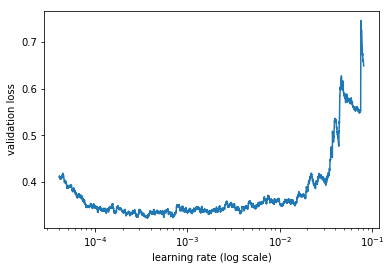

In [32]:
m.sched.plot(1000)

In [33]:
lr=1e-3

In [38]:
# bk = PlotDLTraining(m)

In [39]:
%%time
m.fit(lr, n_cycle=4, metrics=[RMSE], best_save_name='mercari_best')

epoch      trn_loss   val_loss   RMSE                           
    0      0.304084   0.308679   0.554537  
    1      0.308019   0.305189   0.551351                       
    2      0.29678    0.30178    0.548248                       
    3      0.301146   0.308438   0.55418                        
CPU times: user 4min 22s, sys: 26.3 s, total: 4min 48s
Wall time: 4min 23s


[array([0.30844]), 0.5541798955746016]

In [40]:
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 3]),
                           ('trainable', True),
                           ('nb_params', 18)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 240450)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 6)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 6]),
                           ('trainable', True),
                           ('nb_params', 72)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1]

In [41]:
m.save(f'{MODELS_PATH}/m0')

In [42]:
m.load(f'{MODELS_PATH}/m0')

In [43]:
x,y=m.predict_with_targs()

In [44]:
RMSE(x,y)

0.55537164

In [45]:
pred_test=m.predict(is_test=True)

In [46]:
pred_test.shape

(693359, 1)

In [54]:
submission = pd.DataFrame(pred_test).reset_index()

In [58]:
submission.columns = ['test_id', 'price']

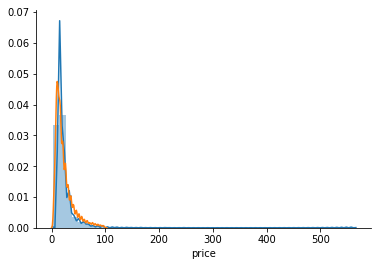

In [78]:
ax = sns.distplot(submission['price'])
sns.distplot(np.exp(y_test), ax = ax, hist=False, kde_kws={'clip': (0.0, 100.0)})
sns.despine()

In [80]:
submission.to_csv('../submission/subm.csv', index = False)

In [82]:
! kg submit -c mercari-price-suggestion-challenge ../submission/subm.csv

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
Expecting value: line 1 column 1 (char 0)


In [48]:
pred_test.shape

(693359, 1)

In [50]:
X_test

,item_condition_id,brand_name,shipping,main_cat,sub_cat1,sub_cat2
train_id,,,,,,
0,1,missing,1,Women,Jewelry,Rings
1,1,missing,1,Other,Office supplies,Shipping Supplies
2,1,Coach,1,Vintage & Collectibles,Bags and Purses,Handbag
3,2,missing,0,Women,Sweaters,Cardigan
4,3,missing,1,Other,Books,Religion & Spirituality
5,1,missing,1,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins"
6,3,Vintage,1,Women,Jewelry,Necklaces
7,1,missing,1,Women,Women's Accessories,Watches
8,3,MARC JACOBS,0,Beauty,Fragrance,Women


In [ ]:
type(pred_test.flatten())

In [ ]:
np.stack((pred_test.flatten(), y_test))

In [ ]:
RMSE(pred_test.flatten(), y_test)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
test_kg = pd.read_feather(f'{PATH}/test.fth')
train_kg = pd.read_feather(f'{PATH}/train.fth')

test_kg.set_index('train_id', drop=True, inplace=True)
train_kg.set_index('train_id', drop=True, inplace=True)

In [ ]:
train_cats(train_kg) 
apply_cats(test_kg, train_kg)

In [ ]:
df_train_kg, y_train_kg, nas = proc_df(train_kg, 'price')
df_test_kg, _, nas = proc_df(test_kg, na_dict=nas)

In [ ]:
df_test_kg.as_matrix()[0][3]

In [ ]:
preds= m.predict_array(df_test_kg.as_matrix(), x_cont=None)